In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import kerastuner as kt
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense
from sklearn import metrics

In [3]:
TrainTx = pd.read_csv('../input/type-data-nbaiot-processed/TrainTx.csv' )
TrainTy = pd.read_csv('../input/type-data-nbaiot-processed/TrainTy.csv')
ValTx = pd.read_csv('../input/type-data-nbaiot-processed/ValTx.csv' )
ValTy = pd.read_csv('../input/type-data-nbaiot-processed/ValTy.csv')

In [4]:
model = Sequential()
model.add(Dense(72, activation='tanh', input_dim=32))
model.add(Dense(56, activation='relu'))
model.add(Dense(56, activation='relu'))
model.add(Dense(56, activation='relu'))
model.add(Dense(72, activation='relu'))
model.add(Dense(11, activation='softmax'))
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [6]:
model.fit(TrainTx, TrainTy, validation_data=(ValTx, ValTy), epochs=20)

Epoch 1/20
9529/9529 [==============================] - 28s 3ms/step - loss: 0.1907 - accuracy: 0.8803 - val_loss: 0.1823 - val_accuracy: 0.8845
Epoch 2/20
9529/9529 [==============================] - 29s 3ms/step - loss: 0.1812 - accuracy: 0.8839 - val_loss: 0.1776 - val_accuracy: 0.8862
Epoch 3/20
9529/9529 [==============================] - 28s 3ms/step - loss: 0.1760 - accuracy: 0.8858 - val_loss: 0.1786 - val_accuracy: 0.8837
Epoch 4/20
9529/9529 [==============================] - 29s 3ms/step - loss: 0.1710 - accuracy: 0.8876 - val_loss: 0.1650 - val_accuracy: 0.8886
Epoch 5/20
9529/9529 [==============================] - 28s 3ms/step - loss: 0.1680 - accuracy: 0.8883 - val_loss: 0.1650 - val_accuracy: 0.8891
Epoch 6/20
9529/9529 [==============================] - 28s 3ms/step - loss: 0.1660 - accuracy: 0.8903 - val_loss: 0.1625 - val_accuracy: 0.8918
Epoch 7/20
9529/9529 [==============================] - 28s 3ms/step - loss: 0.1639 - accuracy: 0.8903 - val_loss: 0.1573 - val_ac

In [7]:
import pickle
with open('ANN.pkl', 'wb') as file:
    pickle.dump(model, file)

In [8]:
import joblib
dt = {
    'ANNtype':model,
}
joblib.dump(dt, 'ANNtype.joblib')

['ANNtype.joblib']

## Accuracies

In [9]:
def accFinder(X, y):
    return metrics.accuracy_score(pd.DataFrame(model.predict(X)).idxmax(axis=1), y)

In [10]:
acc_card = []

In [11]:
acc_card.append(accFinder(TrainTx, TrainTy))

9529/9529 [==============================] - 14s 1ms/step


In [13]:
acc_card.append(accFinder(ValTx, ValTy))

4084/4084 [==============================] - 6s 1ms/step


In [19]:
TestTx = pd.read_csv('../input/type-data-nbaiot-processed/TestTx.csv')
TestTy = pd.read_csv('../input/type-data-nbaiot-processed/TestTy.csv')

In [20]:
acc_card.append(accFinder(TestTx, TestTy))

5835/5835 [==============================] - 8s 1ms/step


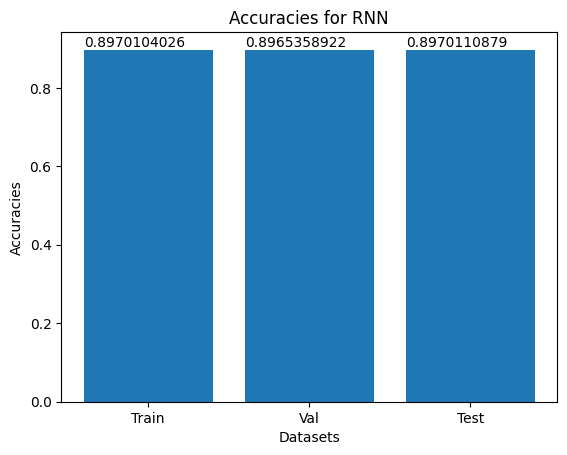

In [21]:
# Create a list of indices for the x-axis
indices = range(len(acc_card))
# Create the bar graph
bars = plt.bar(indices, acc_card)
# Optionally, you can set the labels for the x-axis to be something other than the indices
labels = ['Train', 'Val', 'Test']
plt.xticks(indices, labels)
# Labeling the axes
plt.xlabel('Datasets')
plt.ylabel('Accuracies')
# Giving a title to the graph
plt.title('Accuracies for RNN')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval, '{:.10f}'.format(yval), va='bottom') # va: vertical alignment
plt.show()

## Confusion Matrix

In [22]:
from sklearn.metrics import confusion_matrix

In [23]:
TestPreds = pd.DataFrame(model.predict(TestTx)).idxmax(axis=1)

5835/5835 [==============================] - 9s 2ms/step


In [24]:
cm = pd.DataFrame(confusion_matrix(pd.DataFrame(TestPreds), TestTy, labels=range(11)))
cm

,0,1,2,3,4,5,6,7,8,9,10
0,18605,5,4,11,10,5,1,0,0,2,0
1,4,18497,283,2,0,1,0,0,5,0,0
2,0,78,8986,0,0,0,0,0,1,0,0
3,22,2,1,9388,0,6,0,2,0,0,0
4,4,0,0,0,5,5,0,0,0,0,0
5,3,0,0,7,18630,18660,1,0,2,0,2
6,3,0,0,0,0,0,18617,0,0,19,42
7,0,0,0,3,0,0,0,18842,8,0,0
8,0,1,0,0,0,0,0,1,18696,0,0
9,0,0,0,0,0,0,7,1,0,18488,4


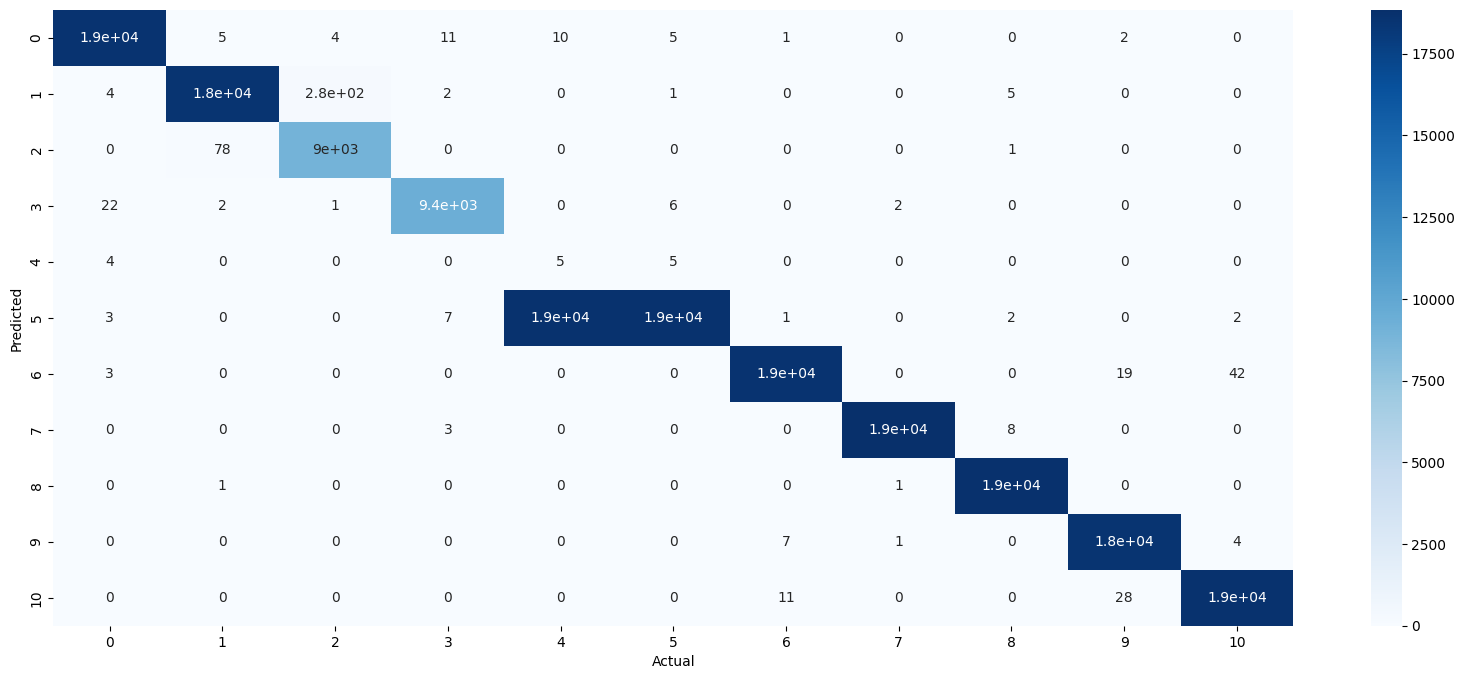

In [27]:
plt.figure(figsize=(20, 8)) 
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Actual')
plt.ylabel('Predicted');

In [28]:
def recall(type, TestPreds, TestDy, labels):
    confMat = confusion_matrix(TestPreds, TestDy, labels=labels)
    true = confMat[type][type]
    total = 0
    for i in range(len(labels)):
        total += confMat[i][type]
    return true/total

def precision(type, TestPreds, TestDy, labels):
    confMat = confusion_matrix(TestPreds, TestDy, labels=labels)
    true = confMat[type][type]
    total = 0
    for i in range(len(labels)):
        total += confMat[type][i]
    return true/total

def specificity(type, TestPreds, TestDy, labels):
    confMat = confusion_matrix(TestPreds, TestDy, labels=labels)
    true = 0
    for i in range(len(labels)):
        if(i==type):
            continue;
        true += confMat[i][i]
    total = 0
    for j in range(len(labels)):
        if(j==type):
            continue
        for i in range(len(labels)):
            total += confMat[i][j]
    return true/total

In [29]:
labels = range(11)

In [31]:
for i in range(len(labels)):
    print('recall of class '+str(i)+': '+str(recall(i, TestPreds, TestDy, labels)))

recall of class 0: 0.9980687731344885
recall of class 1: 0.9953721142980143
recall of class 2: 0.9689454388613328
recall of class 3: 0.9975560514291786
recall of class 4: 0.0002681684097613301
recall of class 5: 0.9990897895807678
recall of class 6: 0.9989268659118957
recall of class 7: 0.9997877533694153
recall of class 8: 0.9991449337323642
recall of class 9: 0.9973566380752009
recall of class 10: 0.9974368558765419


In [32]:
for i in range(len(labels)):
    print('precision of class '+str(i)+': '+str(precision(i, TestPreds, TestDy, labels)))

precision of class 0: 0.9979617014429009
precision of class 1: 0.9843018305661984
precision of class 2: 0.9912851627137341
precision of class 3: 0.9964971871351237
precision of class 4: 0.35714285714285715
precision of class 5: 0.5002010454362686
precision of class 6: 0.9965740592045393
precision of class 7: 0.9994165384819392
precision of class 8: 0.9998930366884159
precision of class 9: 0.9993513513513513
precision of class 10: 0.9979164440645368


In [33]:
for i in range(len(labels)):
    print('specificity of class '+str(i)+': '+str(specificity(i, TestPreds, TestDy, labels)))

specificity of class 0: 0.8858011651363591
specificity of class 1: 0.8861379954433783
specificity of class 2: 0.8932508905622942
specificity of class 3: 0.8916735766785688
specificity of class 4: 0.9965068880359428
specificity of class 5: 0.8856636093635611
specificity of class 6: 0.885708675239359
specificity of class 7: 0.8854710326255333
specificity of class 8: 0.8856338330019408
specificity of class 9: 0.8859491058738173
specificity of class 10: 0.8858141376374559
